In [1]:
import numpy as np
import pandas as pd
import json

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GroupKFold

import scipy
from scipy.stats import norm
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import NonlinearConstraint


from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel)
from sklearn.model_selection import train_test_split


import GPy
import GPyOpt
from numpy.random import seed

In [2]:
BasalMedia_PBMC = pd.read_excel("PBMCs_Data.xlsx", "BasalMedia").iloc[:,1:]
Via_Mean = np.nanmean(BasalMedia_PBMC.iloc[:,5:10].values, axis = 1)

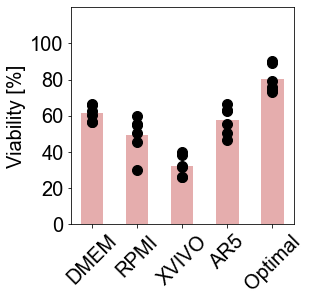

In [3]:
params = {'axes.titlesize': 20, 'xtick.labelsize': 20, 'ytick.labelsize': 20, 'axes.labelsize': 20}
hfont = {'fontname':'Arial'} #, 'weight' : 'bold'
plt.rcParams.update(params)
plt.rcParams["figure.figsize"] = (4, 4)
f, ax = plt.subplots(1, 1)

Control = pd.read_excel("PBMCs_Data.xlsx", "Control").iloc[:,1:]
x = [[0]*6, [1]*6, [2]*6, [3]*6, [4]*6]
label_names = ['DMEM', 'RPMI','XVIVO','AR5', 'Optimal']

barlist = ax.bar([0 , 1, 2, 3, 4], np.mean(Control.iloc[:,4:].values, axis =1), width = 0.5,facecolor= 'indianred', alpha = 0.5)
ax.set_ylabel('Viability [%]', **hfont)
ax.scatter(x, Control.iloc[:,4:].values,100, 'k')
ax.set_xticks([0, 1, 2,3,4], **hfont)
ax.set(ylim=[0, 120])
ax.set_yticks(np.arange(0, 120, 20),**hfont)
ax.set_yticklabels(np.arange(0, 120, 20), **hfont)
ax.set_xticklabels(label_names, rotation = 45, **hfont)
plt.savefig("Viability_PBMC", dpi = 600, bbox_inches = 'tight')

In [4]:
from scipy import stats
stats.ttest_ind(Control.iloc[0,4:], Control.iloc[4,4:], equal_var=False)

Ttest_indResult(statistic=-5.271099124279913, pvalue=0.0007720273582813031)

slateblue
orchid


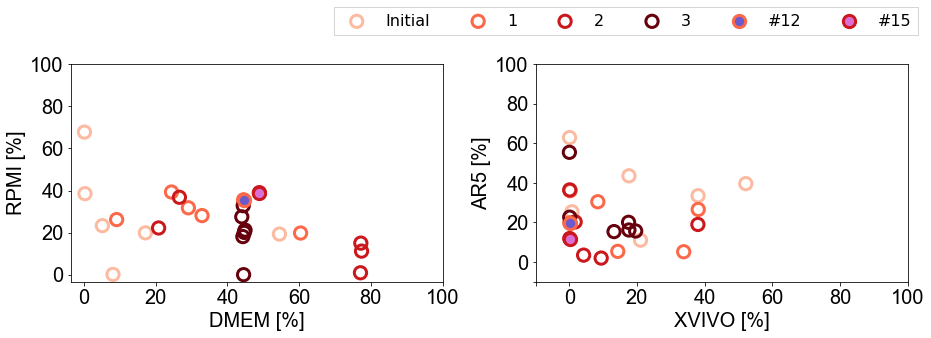

In [5]:
params = {'axes.titlesize': 20, 'xtick.labelsize': 20, 'ytick.labelsize': 20, 'axes.labelsize': 20}
hfont = {'fontname':'Arial'}
plt.rcParams.update(params)
plt.rcParams["figure.figsize"] = (15,4)
fig, axs = plt.subplots(1, 2, gridspec_kw={'hspace':0.1, 'wspace': 0.25})

cmap = matplotlib.cm.get_cmap('Reds')

# plt.figure()
for r in range(4):
    axs[0].scatter(BasalMedia_PBMC.iloc[r*6:(r+1)*6,0], BasalMedia_PBMC.iloc[r*6:(r+1)*6,1], 
                   c='None', edgecolors = cmap((r+1)/4),
                   linewidths = 3, 
                  s = 150) 
    
    
    
    axs[1].scatter(BasalMedia_PBMC.iloc[r*6:(r+1)*6,2], BasalMedia_PBMC.iloc[r*6:(r+1)*6,3],
                 c='None', edgecolors = cmap((r+1)/4),  linewidths = 3,  # c = cmap((r+1)/4),
                 s = 150) 
    axs[1].set_ylim([0, 100])
    
col_name = ['slateblue', 'orchid']
cnt = 0
r_count = [1, 2]
for i in [11 ,14]:
    print(col_name[cnt])
    axs[0].scatter(BasalMedia_PBMC.iloc[i,0], BasalMedia_PBMC.iloc[i,1], c=col_name[cnt], edgecolors = cmap((r_count[cnt]+1)/4), 
                   linewidths = 3, s = 150) 
    axs[0].set_xticks(ticks=np.arange(0,101, 20), labels= np.arange(0,101, 20), **hfont)
    axs[0].set_yticks(ticks=np.arange(0,101, 20), labels= np.arange(0,101, 20), **hfont)
    axs[0].set_xlabel('DMEM [%]', **hfont) 
    axs[0].set_ylabel('RPMI [%]', **hfont) 
    
    axs[1].scatter(BasalMedia_PBMC.iloc[i,2], BasalMedia_PBMC.iloc[i,3], linewidths = 3, c=col_name[cnt], edgecolors = cmap((r_count[cnt]+1)/4),
                  s = 150) 
    axs[1].set_xlabel('XVIVO [%]', **hfont) 
    axs[1].set_ylabel('AR5 [%]', **hfont) 
    axs[1].set_xticks(ticks=[-10] + np.arange(0,101, 20).tolist(), labels= [''] + np.arange(0,101, 20).tolist(), **hfont)
    axs[1].set_yticks(ticks=[-10] + np.arange(0,101, 20).tolist(), labels= [''] + np.arange(0,101, 20).tolist(), **hfont)
    
    cnt = cnt + 1
    axs[0].legend(['Initial', '1', '2', '3','#12', '#15'], loc = 'upper right',fontsize = 16,
          ncol=7, bbox_to_anchor=(2.3, 1.3), fancybox=False, shadow=False) #
#     axs[1].legend(['#12', '#15'], loc = 'upper right',fontsize = 16,
#           ncol=1, fancybox=False, shadow=False)
    

    
plt.savefig("PBMC_MediBlending.pdf", dpi = 600, bbox_inches = "tight")

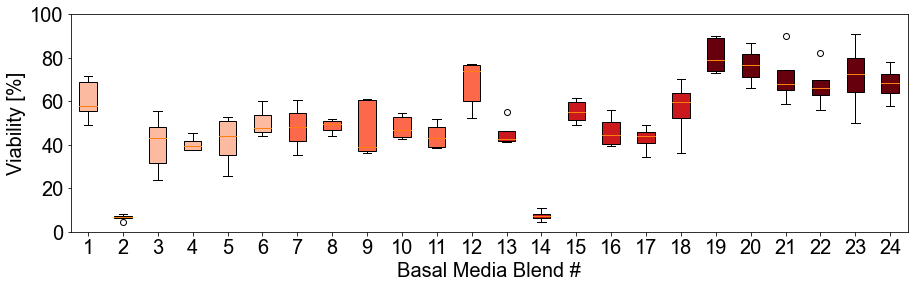

In [10]:
params = {'axes.titlesize': 20, 'xtick.labelsize': 20, 'ytick.labelsize': 20, 'axes.labelsize': 20}
hfont = {'fontname':'Arial'}
plt.rcParams.update(params)
plt.rcParams["figure.figsize"] = (15,4)
fig, axs = plt.subplots(1, 1, gridspec_kw={'hspace':0.1, 'wspace': 0.25})

cmap = matplotlib.cm.get_cmap('Reds')
colors = []
for r in range(4):
    colors = colors + [cmap((r+1)/4)] * 6

data = BasalMedia_PBMC.iloc[:,5:10].T.values
mask = ~np.isnan(data)
filtered_data = [d[m] for d, m in zip(data.T, mask.T)]

bp = axs.boxplot(filtered_data, patch_artist=True)

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    
axs.set_yticks(ticks=np.arange(0,101, 20), labels= np.arange(0,101, 20), **hfont)
axs.set_xticks(ticks=np.arange(1,25, 1), labels= np.arange(1,25, 1), **hfont)
axs.set_xlabel('Basal Media Blend #', **hfont) #xlabel=Column_Names[1],
axs.set_ylabel('Viability [%]', **hfont) #xlabel=Column_Names[1],

plt.savefig("PBMC_Viability.pdf", dpi = 600, bbox_inches = "tight")